# Train and validate ML model for phenotypic classification of nuclei

### Use training data with DeepProfiler features from [training_data.csv.gz](../1.format_data/data/training_data.csv.gz)

### Import libraries


In [1]:
import pandas as pd
import numpy as np
import pathlib
from typing import Tuple, Any, List, Union

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import seaborn as sns

### Helper functions for data loading, training, and validation


In [2]:
def get_training_data(load_path: pathlib.Path) -> pd.DataFrame:
    """get DP training data from csv at load path

    Args:
        load_path (pathlib.Path): path to training data csv

    Returns:
        pd.DataFrame: training dataframe
    """
    # read dataset into pandas dataframe
    training_data = pd.read_csv(load_path, index_col=0)

    # remove training data with ADCCM class as this class was not used for classification in original paper
    training_data = training_data[
        training_data["Mitocheck_Phenotypic_Class"] != "ADCCM"
    ]

    # replace shape1 and shape3 labels with their correct respective classes
    training_data = training_data.replace("Shape1", "Binuclear")
    training_data = training_data.replace("Shape3", "Polylobed")

    return training_data


def get_X_y_data(load_path: pathlib.Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """generate X (features) and y (labels) dataframes from training data

    Args:
        load_path (pathlib.Path): path to training data csv

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: X, y dataframes
    """
    training_data = get_training_data(load_path)

    # all features from DeepProfiler have "efficientnet" in their column name
    morphology_features = [
        col for col in training_data.columns.tolist() if "efficientnet" in col
    ]

    # extract features
    X = training_data.loc[:, morphology_features].values

    # extract phenotypic class label
    y = training_data.loc[:, ["Mitocheck_Phenotypic_Class"]].values
    # make Y data
    y = np.ravel(y)

    # shuffle data because as it comes from MitoCheck same labels tend to be in grou
    X, y = shuffle(X, y, random_state=0)

    return X, y

### Load training data and create stratified folds for cross validation

In [3]:
# load x (features) and y (labels) dataframes
load_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")
X, y = get_X_y_data(load_path)

print(X.shape)
print(y.shape)

# create stratified data sets for k-fold cross validation
straified_k_folds = StratifiedKFold(n_splits=10, shuffle=False)

(4123, 1280)
(4123,)


### Define model without C/l1_ratio parameters

In [4]:
# create logistic regression model with following parameters
log_reg_model = LogisticRegression(
    penalty="elasticnet", solver="saga", max_iter=100, n_jobs=-1, random_state=0
)

### Perform grid search for best C and l1_ratio parameters

In [5]:
# hypertune parameters with GridSearchCV
parameters = {"C": np.logspace(-3, 3, 7), "l1_ratio": np.linspace(0, 1, 11)}
#parameters = {"C": [1.0], "l1_ratio": [0.8]}
print(f"Parameters being tested: {parameters}")
grid_search_cv = GridSearchCV(
    log_reg_model, parameters, cv=straified_k_folds, n_jobs=-1
)
grid_search_cv = grid_search_cv.fit(X, y)

Parameters being tested: {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

In [6]:
print(f"Best parameters: {grid_search_cv.best_params_}")
print(f"Score of best estimator: {grid_search_cv.best_score_}")
log_reg_model = LogisticRegression(
    C=grid_search_cv.best_params_["C"],
    l1_ratio=grid_search_cv.best_params_["l1_ratio"],
    penalty="elasticnet",
    solver="saga",
    max_iter=100,
    n_jobs=-1,
    random_state=0,
)

Best parameters: {'C': 1.0, 'l1_ratio': 0.8}
Score of best estimator: 0.8103316956204895


### Evaluate predictive performance of model

In [7]:
# create confusion matrix for logistic regression model after cross validation
y_pred = cross_val_predict(log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred, labels=grid_search_cv.best_estimator_.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = grid_search_cv.best_estimator_.classes_
conf_mat.index = grid_search_cv.best_estimator_.classes_

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

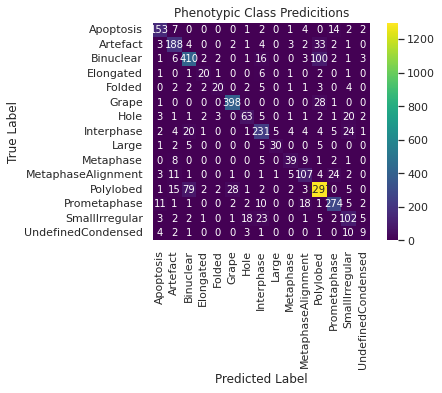

In [8]:
sns.set(rc={"figure.figsize": (15, 15)})
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

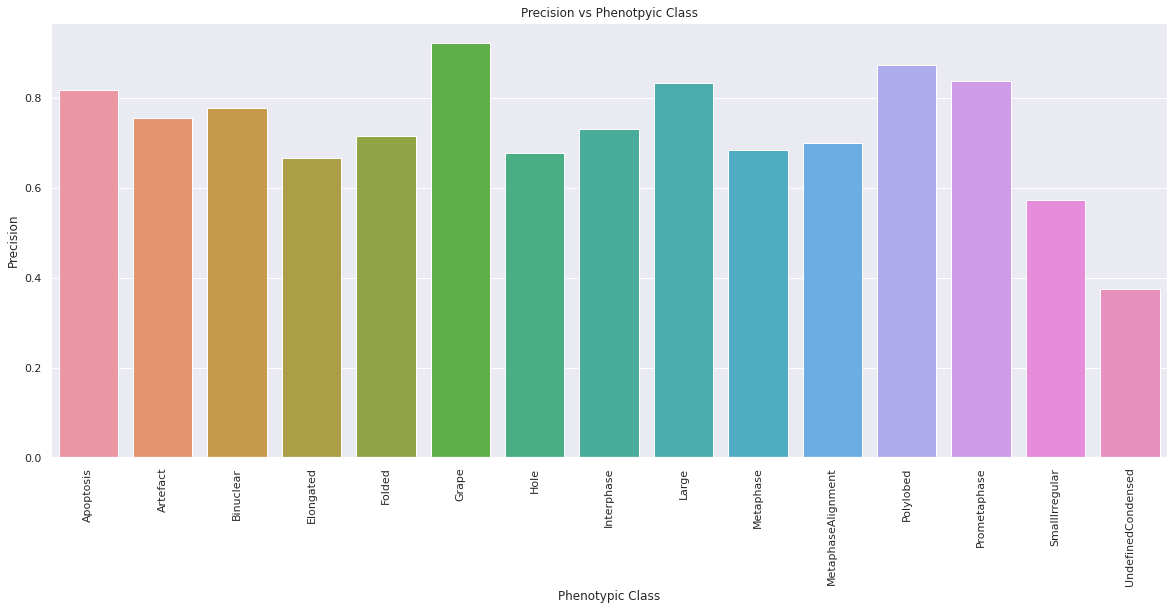

In [9]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y, y_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = columns=grid_search_cv.best_estimator_.classes_

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

### Compile best estimator coefficients matrix

In [10]:
coefs = np.abs(grid_search_cv.best_estimator_.coef_)
coefs = pd.DataFrame(coefs).T
coefs.columns = grid_search_cv.best_estimator_.classes_

print(coefs.shape)
coefs.head()

(1280, 15)


,Apoptosis,Artefact,Binuclear,Elongated,Folded,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,Polylobed,Prometaphase,SmallIrregular,UndefinedCondensed
0,0.001056,0.012372,0.050253,0.007608,0.029902,0.027314,0.018075,0.034660,0.023878,4.501221e-07,0.058257,0.032968,0.054135,0.106888,0.000000
1,0.000000,0.007407,0.060535,0.000000,0.065003,0.037339,0.022459,0.049629,0.000000,0.000000e+00,0.000000,0.091550,0.000000,0.034205,0.000000
2,0.003483,0.057906,0.013435,0.000000,0.000000,0.000000,0.012217,0.026380,0.000000,0.000000e+00,0.037089,0.159860,0.027706,0.064532,0.019566
3,0.000000,0.031654,0.089368,0.026404,0.000000,0.028902,0.056322,0.174200,0.006965,2.971849e-02,0.021986,0.022481,0.002964,0.000000,0.000000
4,0.063237,0.081776,0.123272,0.000000,0.002622,0.000000,0.036089,0.000415,0.000000,8.146595e-02,0.012693,0.090481,0.004985,0.055999,0.008082


### Save predictions, average precisions, and coefficients

In [11]:
# make results dir for saving
results_dir = pathlib.Path("results/")
results_dir.mkdir(parents=True, exist_ok=True)

# save predicitons
y_dataframe = pd.DataFrame([y,y_pred]).T
y_dataframe.columns = ["True Phenotypic Class", "Predicted Phenotypic Class"]
y_dataframe.to_csv(f"{results_dir}/predictions.tsv", sep="\t")

# save average precisions
precisions.to_csv(f"{results_dir}/precisions.tsv", sep="\t")

# save final estimator coefficients
coefs.to_csv(f"{results_dir}/coefficients.tsv", sep="\t")

### Diagrams for interpreting coefficients

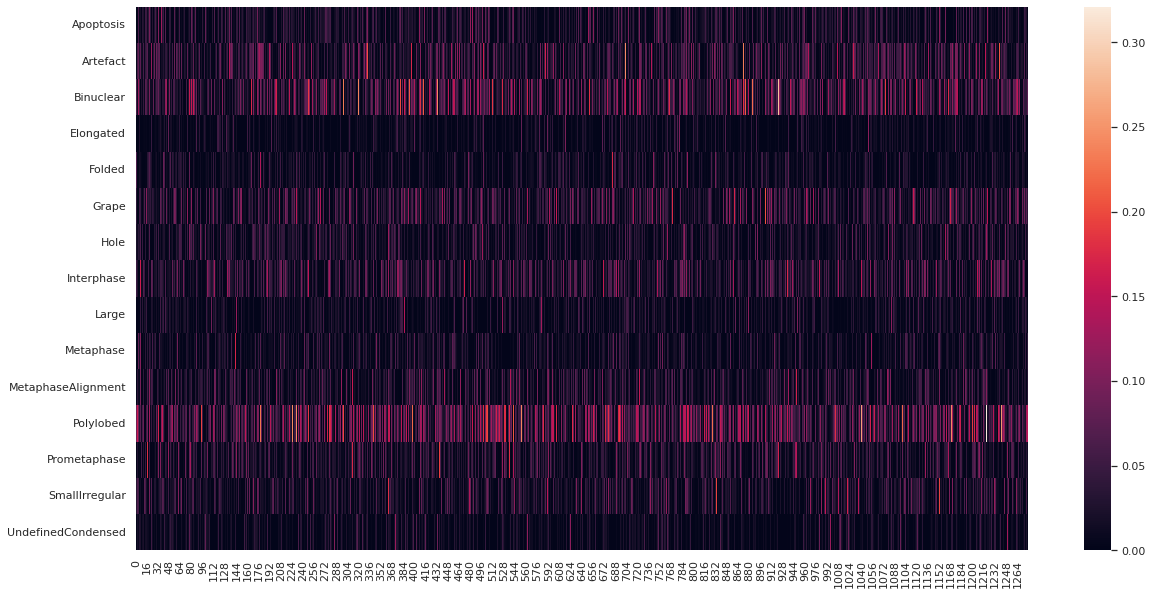

In [12]:
# display heatmap of average coefs
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(data=coefs.T)

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Clustered Heatmap of Coefficients Matrix')

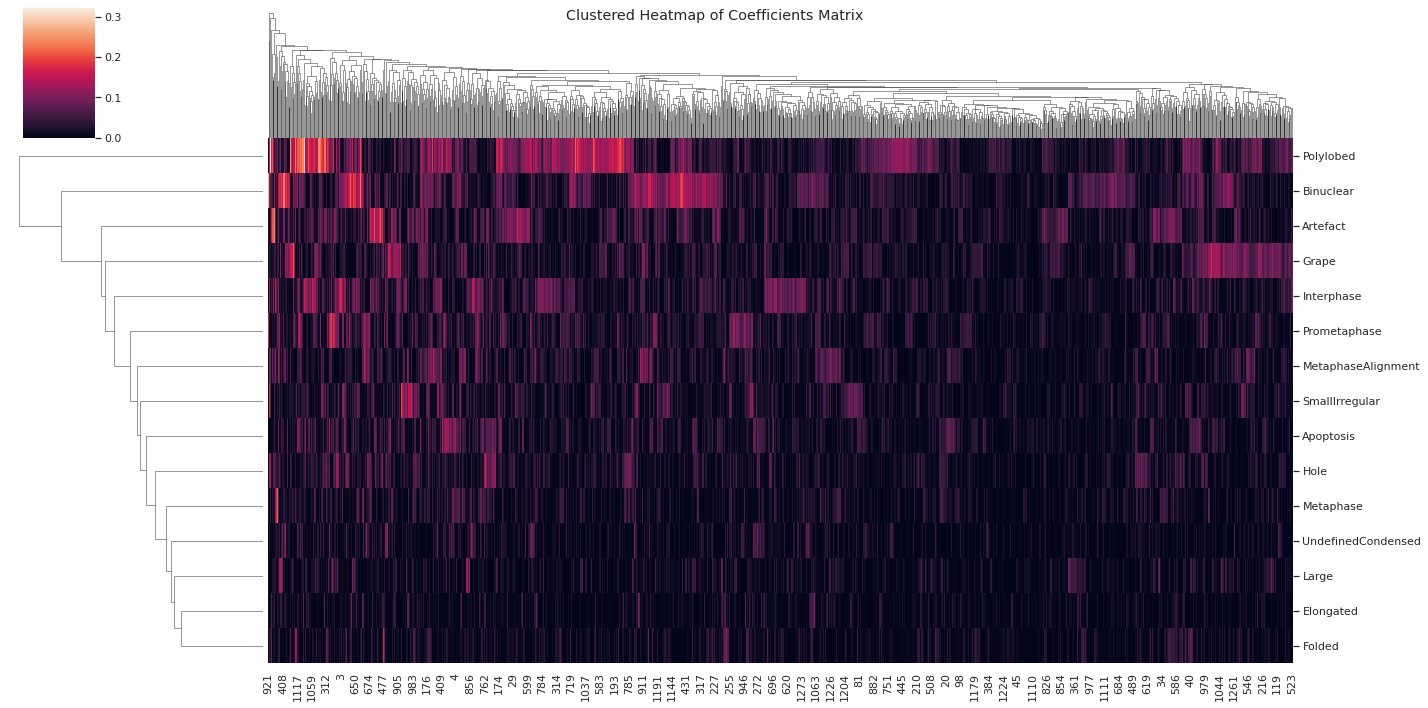

In [13]:
# display clustered heatmap of coefficients
ax = sns.clustermap(
    data=coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True
)
ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")

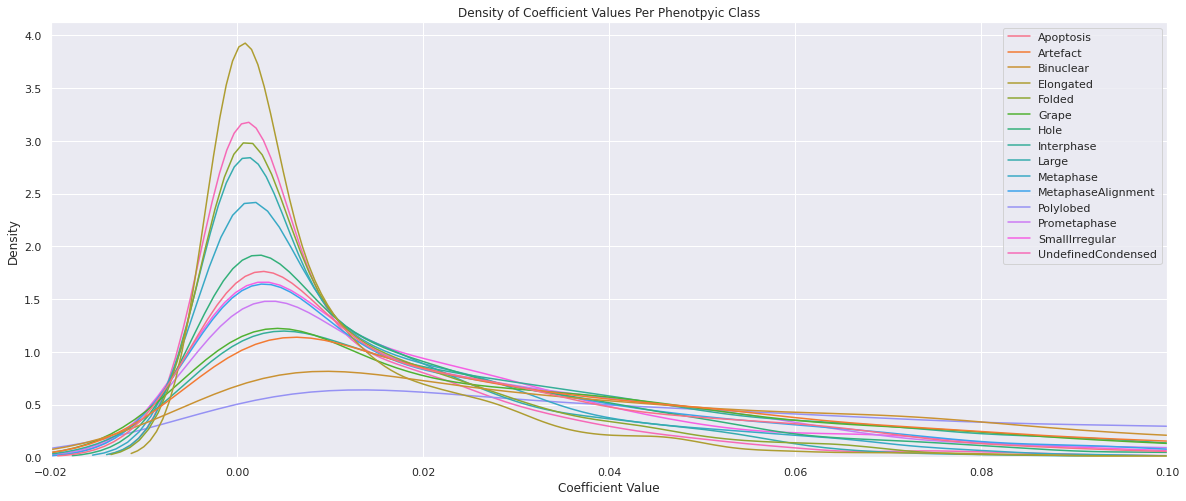

In [14]:
# display density plot for coefficient values of each class
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlim(-0.02, 0.1)
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.title("Density of Coefficient Values Per Phenotpyic Class")
ax = sns.kdeplot(data=coefs)

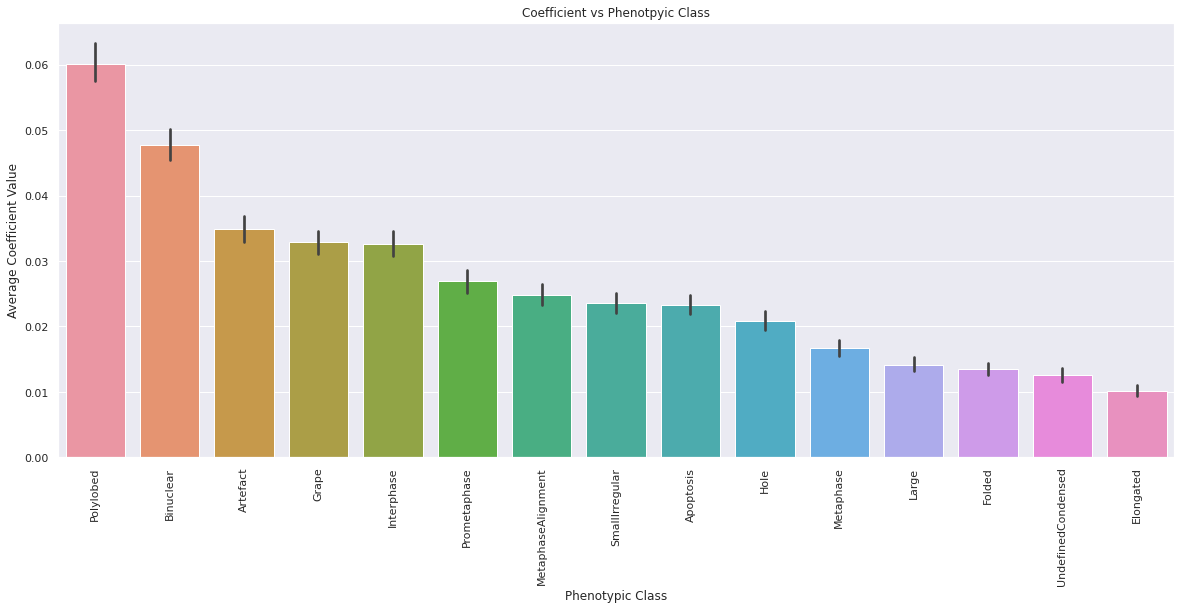

In [15]:
# display average coefficient value vs phenotypic class bar chart
pheno_class_ordered = coefs.reindex(
    coefs.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=pheno_class_ordered)

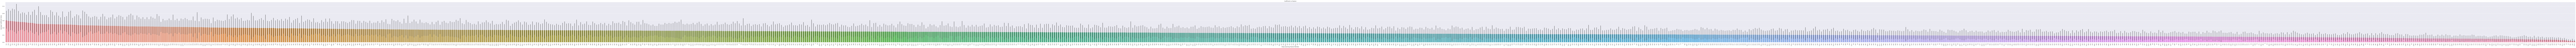

In [16]:
# display average coefficient value vs feature bar chart
feature_ordered = coefs.T.reindex(
    coefs.T.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (500, 8)})
plt.xlabel("Deep Learning Feature Number")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Feature")
plt.xticks(rotation=90)
ax = sns.barplot(data=feature_ordered)

### Repeat process with randomly shuffled baseline

In [17]:
# load x (features) and y (labels) dataframes
load_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")
X, y = get_X_y_data(load_path)
# shuffle y (labels) dataframe to create shuffled baseline
y = shuffle(y, random_state=0)

In [18]:
# create logistic regression model with following parameters
log_reg_model = LogisticRegression(
    penalty="elasticnet", solver="saga", max_iter=100, n_jobs=-1, random_state=0
)

In [19]:
# hypertune parameters with GridSearchCV
parameters = {"C": np.logspace(-3, 3, 7), "l1_ratio": np.linspace(0, 1, 11)}
#parameters = {"C": [1.0], "l1_ratio": [0.8]}
print(f"Parameters being tested: {parameters}")
grid_search_cv = GridSearchCV(
    log_reg_model, parameters, cv=straified_k_folds, n_jobs=-1
)
grid_search_cv = grid_search_cv.fit(X, y)

Parameters being tested: {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

In [20]:
print(f"Best parameters: {grid_search_cv.best_params_}")
print(f"Score of best estimator: {grid_search_cv.best_score_}")
log_reg_model = LogisticRegression(
    C=grid_search_cv.best_params_["C"],
    l1_ratio=grid_search_cv.best_params_["l1_ratio"],
    penalty="elasticnet",
    solver="saga",
    max_iter=100,
    n_jobs=-1,
    random_state=0,
)

Best parameters: {'C': 0.001, 'l1_ratio': 0.1}
Score of best estimator: 0.34853369848844584


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


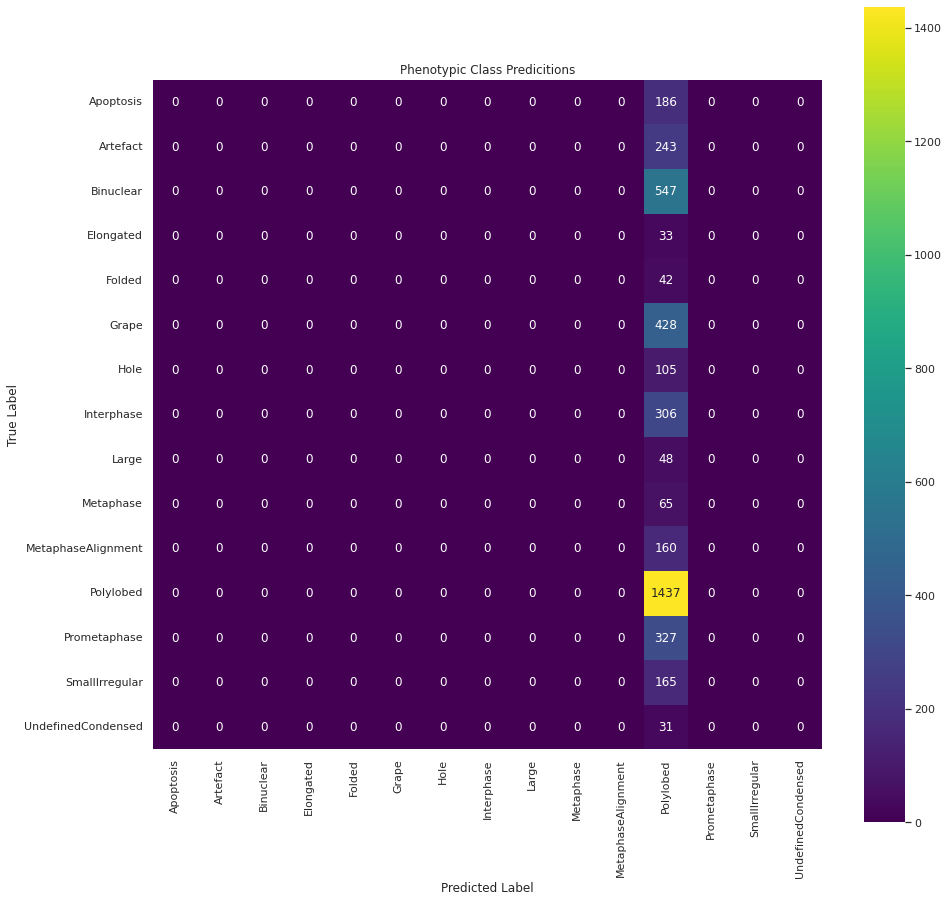

In [21]:
# create confusion matrix for logistic regression model after cross validation
y_pred = cross_val_predict(log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred, labels=grid_search_cv.best_estimator_.classes_)

conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = grid_search_cv.best_estimator_.classes_
conf_mat.index = grid_search_cv.best_estimator_.classes_

sns.set(rc={"figure.figsize": (15, 15)})
ax = sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap="viridis", square=True)
ax = plt.xlabel("Predicted Label")
ax = plt.ylabel("True Label")
ax = plt.title("Phenotypic Class Predicitions")

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


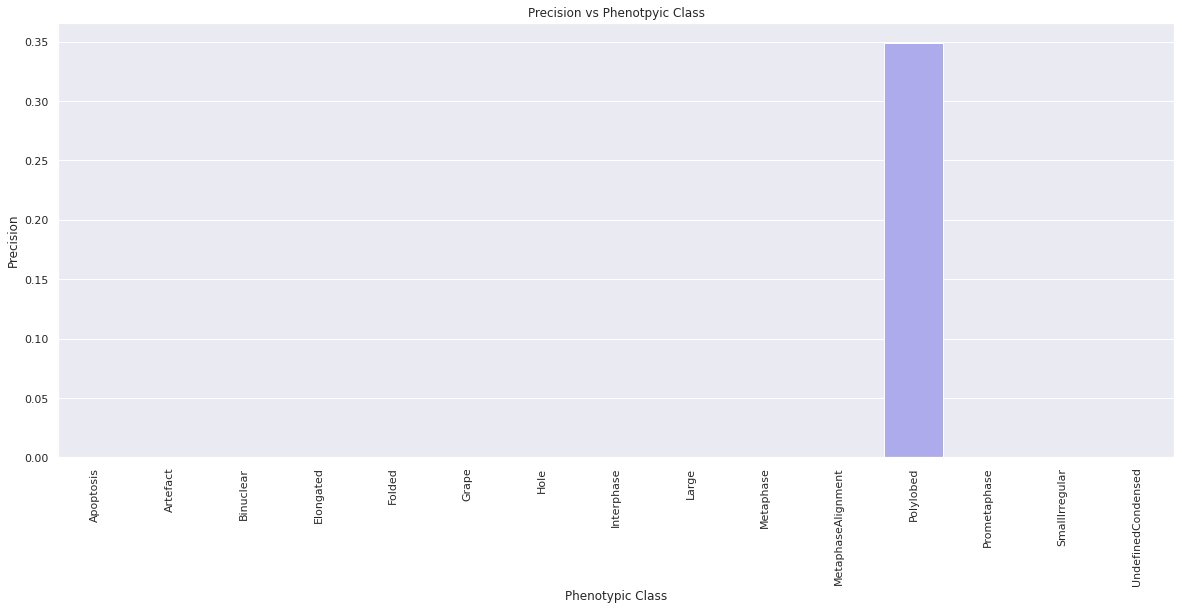

In [22]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y, y_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = columns=grid_search_cv.best_estimator_.classes_

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

In [23]:
coefs = np.abs(grid_search_cv.best_estimator_.coef_)
coefs = pd.DataFrame(coefs).T
coefs.columns = grid_search_cv.best_estimator_.classes_

print(coefs.shape)
coefs.head()

(1280, 15)


,Apoptosis,Artefact,Binuclear,Elongated,Folded,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,Polylobed,Prometaphase,SmallIrregular,UndefinedCondensed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# make results dir for saving
results_dir = pathlib.Path("results/")
results_dir.mkdir(parents=True, exist_ok=True)

# save predicitons
y_dataframe = pd.DataFrame([y,y_pred]).T
y_dataframe.columns = ["True Phenotypic Class", "Predicted Phenotypic Class"]
y_dataframe.to_csv(f"{results_dir}/baseline_predictions.tsv", sep="\t")

# save average precisions
precisions.to_csv(f"{results_dir}/baseline_precisions.tsv", sep="\t")

# save final estimator coefficients
coefs.to_csv(f"{results_dir}/baseline_coefficients.tsv", sep="\t")

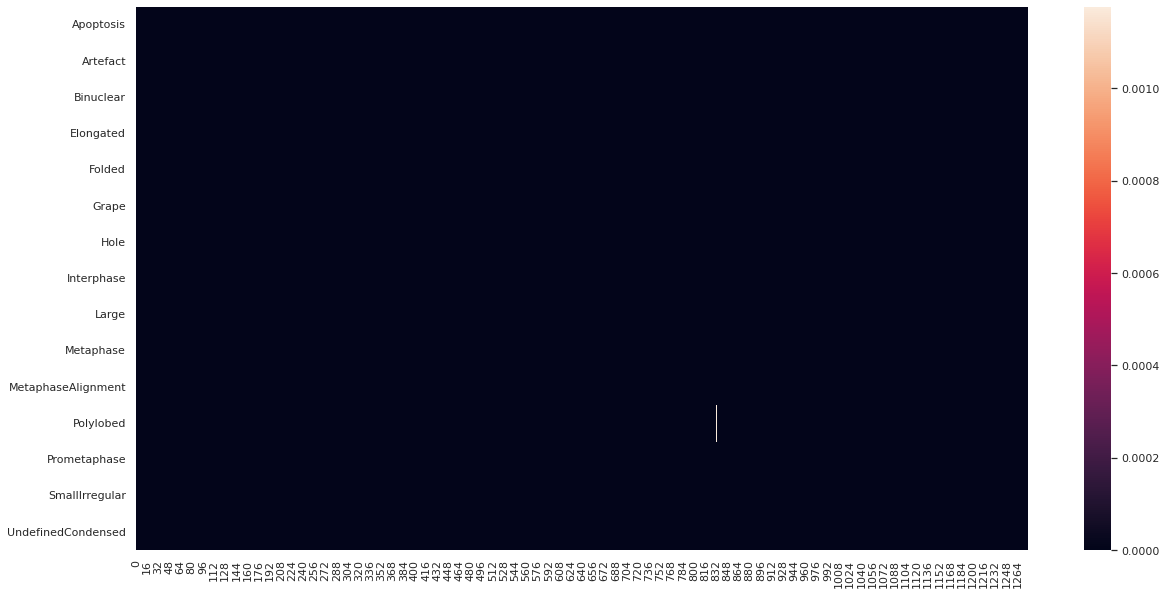

In [25]:
# display heatmap of average coefs
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(data=coefs.T)

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Clustered Heatmap of Coefficients Matrix')

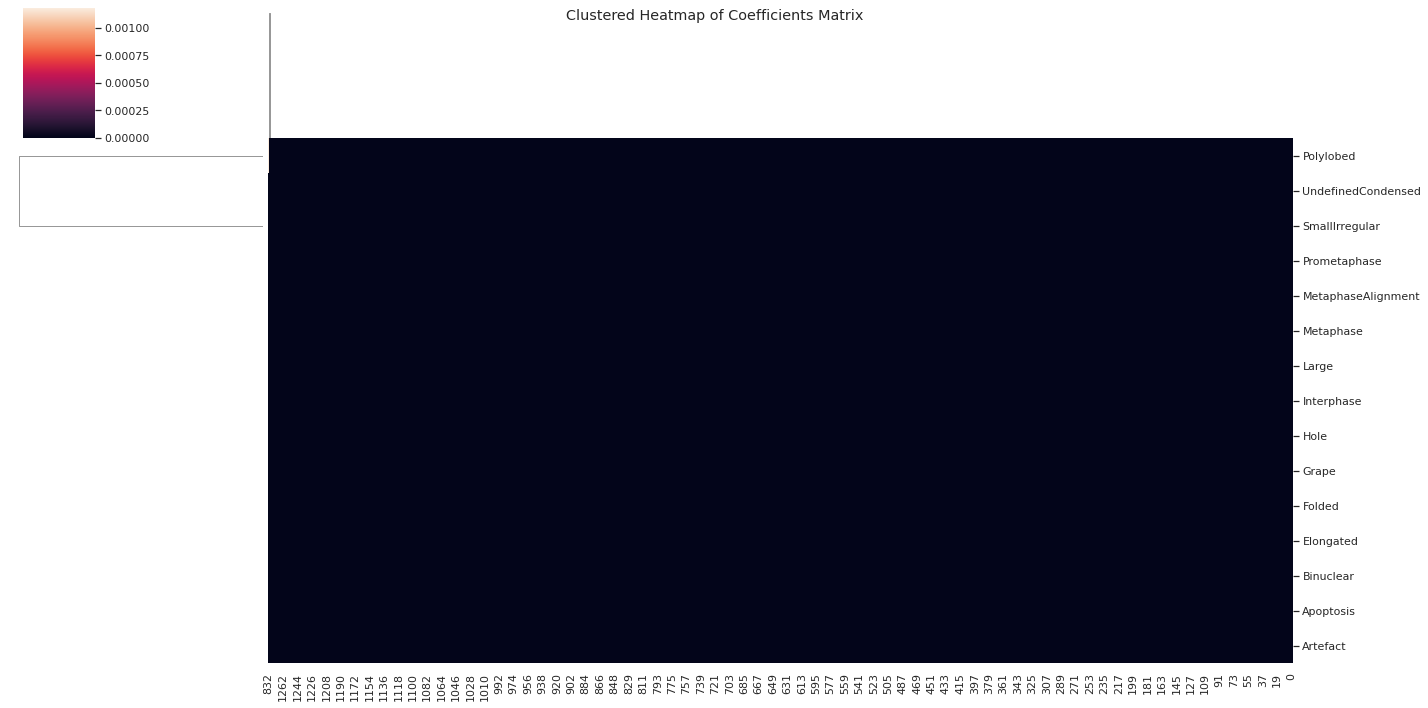

In [26]:
# display clustered heatmap of coefficients
ax = sns.clustermap(
    data=coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True
)
ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


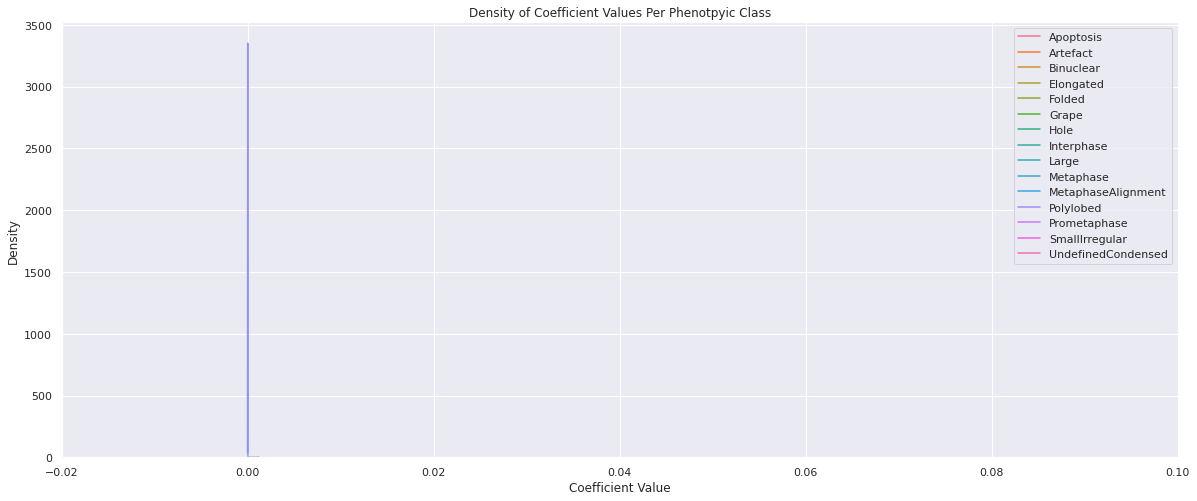

In [27]:
# display density plot for coefficient values of each class
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlim(-0.02, 0.1)
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.title("Density of Coefficient Values Per Phenotpyic Class")
ax = sns.kdeplot(data=coefs)

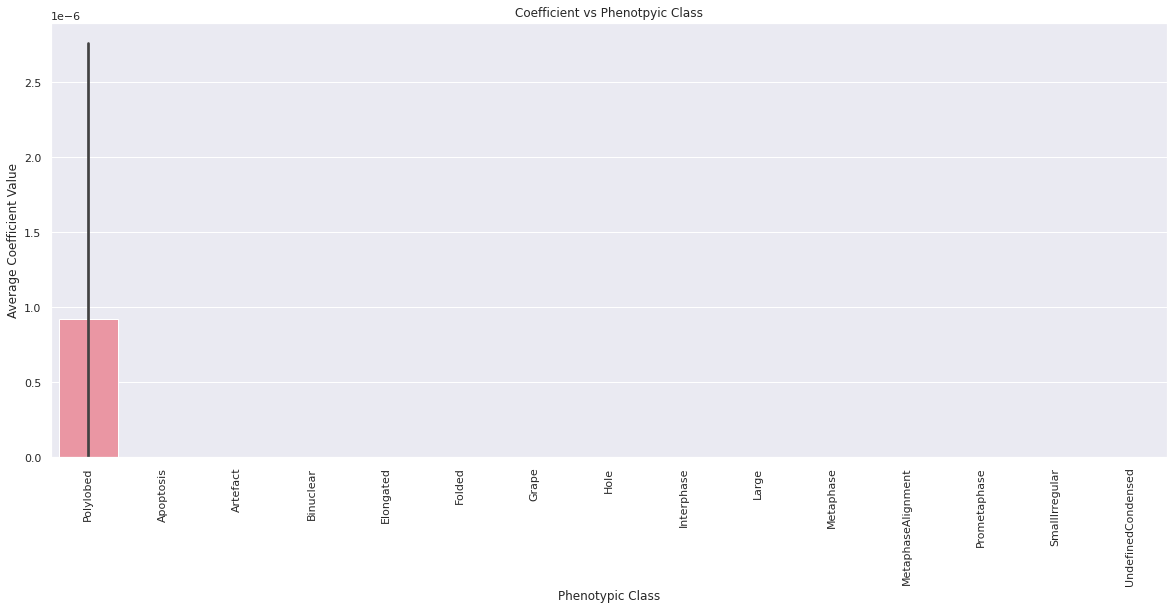

In [28]:
# display average coefficient value vs phenotypic class bar chart
pheno_class_ordered = coefs.reindex(
    coefs.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=pheno_class_ordered)

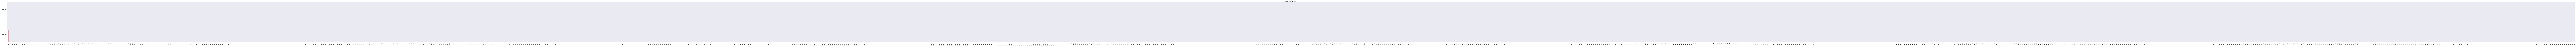

In [29]:
# display average coefficient value vs feature bar chart
feature_ordered = coefs.T.reindex(
    coefs.T.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (500, 8)})
plt.xlabel("Deep Learning Feature Number")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Feature")
plt.xticks(rotation=90)
ax = sns.barplot(data=feature_ordered)